In [26]:
import torch
from torch import nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,random_split
from torch import optim
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from collections import Counter

Text(0, 0.5, 'Number of Images')

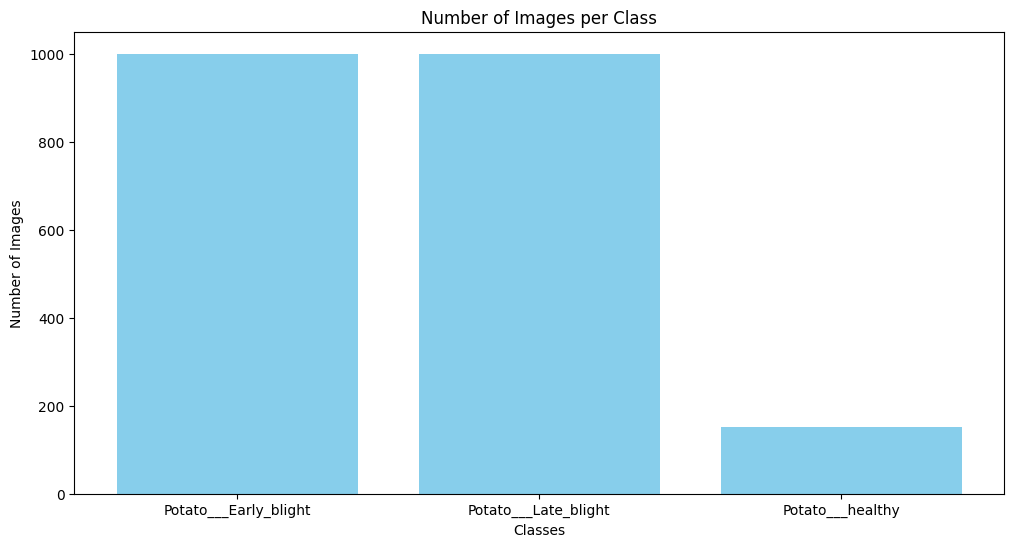

In [27]:
transform=transforms.Compose([
    transforms.ToTensor(),#tranforms to the tensor
    transforms.Resize((256,256),),
    transforms.Normalize((0.5,),(0.5,))#just copied
])
root=r"C:\Users\saipr\OneDrive\Documents\PotatoPlants"
dataset=datasets.ImageFolder(root=root,transform=transform)#it will divide classes w.r.t to no.of folders inside it
# Calculate the number of images in each class
class_counts = Counter([label for _, label in dataset])
class_names = [dataset.classes[i] for i in range(len(dataset.classes))]
class_lengths = [class_counts[i] for i in range(len(dataset.classes))]

# Create the bar graph
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_lengths, color='skyblue')

# Add title and labels
plt.title('Number of Images per Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')

In [28]:
train_size=int(0.6*(len(dataset)))
val_size=int(0.2*(len(dataset)))
test_size=len(dataset)-train_size-val_size
train_data,val_data,test_data=random_split(dataset,[train_size,val_size,test_size])
train_loader=DataLoader(train_data,batch_size=64,shuffle=True)#train_data(that we are passing) should be tensor(my understanding)
val_loader=DataLoader(val_data,batch_size=64,shuffle=True)
test_loader=DataLoader(test_data,batch_size=64,shuffle=True)


In [29]:
class_names=dataset.classes#gives the  classes names
class_idx=dataset.class_to_idx

In [30]:
class CNN(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        self.network=nn.Sequential(#intially I wrote self as nn
            nn.Conv2d(in_channels=3,out_channels=4,kernel_size=3,stride=1,padding=1),#these in channels are rbg colors of a colored photo
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=4,out_channels=8,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Flatten(),     
            nn.Linear(32*8*8,64),
            nn.ReLU(),
            nn.Linear(64,output_size)            
        )
    def forward(self,x):
        return self.network(x)

In [31]:
model=CNN(input_size=256*256,output_size=len(dataset.classes))
criterion=nn.CrossEntropyLoss()
optimiser=optim.Adam(model.parameters(),lr=0.001)

In [32]:
num_epochs=20
train_losses,val_losses=[],[]
model.train()
for epoch in range(num_epochs):
 for input,output in train_loader:
    pred_output=model(input)
    loss=criterion(pred_output,output)
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
 train_losses.append(loss.item()/len(train_loader))
 print(f'Loss in Epoch [{epoch+1}/{num_epochs}]:{loss} ')



Loss in Epoch [1/20]:0.803548276424408 
Loss in Epoch [2/20]:0.808009147644043 
Loss in Epoch [3/20]:0.3241209089756012 
Loss in Epoch [4/20]:0.4270956814289093 
Loss in Epoch [5/20]:0.7370644211769104 
Loss in Epoch [6/20]:0.08661047369241714 
Loss in Epoch [7/20]:0.10313455760478973 
Loss in Epoch [8/20]:0.09067629277706146 
Loss in Epoch [9/20]:0.20565342903137207 
Loss in Epoch [10/20]:0.09724225848913193 
Loss in Epoch [11/20]:0.07041241973638535 
Loss in Epoch [12/20]:0.23612885177135468 
Loss in Epoch [13/20]:0.08905331045389175 
Loss in Epoch [14/20]:0.04528772085905075 
Loss in Epoch [15/20]:0.02175717242062092 
Loss in Epoch [16/20]:0.07644792646169662 
Loss in Epoch [17/20]:0.1432499885559082 
Loss in Epoch [18/20]:0.12028981000185013 
Loss in Epoch [19/20]:0.045062772929668427 
Loss in Epoch [20/20]:0.004922652617096901 


In [33]:

model.eval()
with torch.no_grad():
    for epoch in range(20):
        for input,output in val_loader:
            pred_out=model(input)
            loss=criterion(pred_out,output)
        val_losses.append(loss.item()/len(val_loader))

In [34]:
def ClassificationReport(model,loader):
    y_test,y_pred=[],[]
    model.eval()
    with torch.no_grad():
        for input,output in loader:
            pred_output=model(input)
            y_test.extend(output.numpy())
            y_pred.extend(torch.argmax(pred_output,dim=1).numpy())
    model.train()
    print(classification_report(y_test,y_pred))
    
    for i in range(3):
        tc=sum(1 for y,x in zip(y_pred,y_test) if (y==i)&(x==i))
        ac=sum(1 for y in y_test if y==i)
        print(f'{list(class_idx.keys())[i]}: [{tc}/{ac}]')


In [35]:
print('classification report of training phase:')
ClassificationReport(model,train_loader)


classification report of training phase:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       602
           1       1.00      0.95      0.97       607
           2       0.80      1.00      0.89        82

    accuracy                           0.98      1291
   macro avg       0.93      0.98      0.95      1291
weighted avg       0.98      0.98      0.98      1291

Potato___Early_blight: [602/602]
Potato___Late_blight: [576/607]
Potato___healthy: [82/82]


Classification Report of validation set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       204
           1       0.97      0.92      0.94       193
           2       0.68      0.91      0.78        33

    accuracy                           0.95       430
   macro avg       0.88      0.94      0.90       430
weighted avg       0.96      0.95      0.95       430

Potato___Early_blight: [202/204]
Potato___Late_blight: [177/193]
Potato___healthy: [30/33]


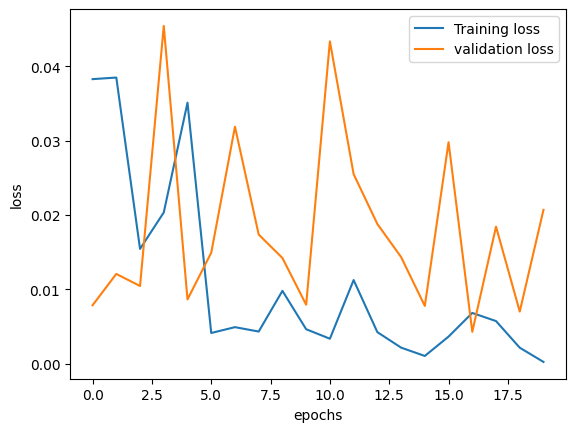

In [36]:
print('Classification Report of validation set:')
ClassificationReport(model,val_loader)
plt.plot(train_losses,label='Training loss')
plt.plot(val_losses,label='validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [37]:
print('Classification Report of testing phase:')
ClassificationReport(model,test_loader)

Classification Report of testing phase:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       194
           1       0.96      0.89      0.92       200
           2       0.67      0.84      0.75        37

    accuracy                           0.93       431
   macro avg       0.86      0.90      0.88       431
weighted avg       0.93      0.93      0.93       431

Potato___Early_blight: [192/194]
Potato___Late_blight: [177/200]
Potato___healthy: [31/37]


In [ ]:
#class weightage
#mirror images to increase the healthy class
#cnn layers photos creating bot